# Integration, label transfer and multi-scale analysis with scPoli

In this notebook we demonstrate an example workflow of data integration, reference mapping, label transfer and multi-scale analysis of sample and cell embeddings using scPoli. We integrate pancreas data obtained from the [scArches reproducibility repository](https://github.com/theislab/scArches-reproducibility).

In [1]:
import os
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/dataset/__init__.py:9: UserWarning: In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
  warnings.warn('In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).')
/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/models/__init__.py:11: UserWarning: In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
  warnings.warn('In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and \n captum (see https://github.com/pytorch/captum).')
Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationW

In [2]:
adata = sc.read('../../../lataq_reproduce/data/pancreas.h5ad')
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [3]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


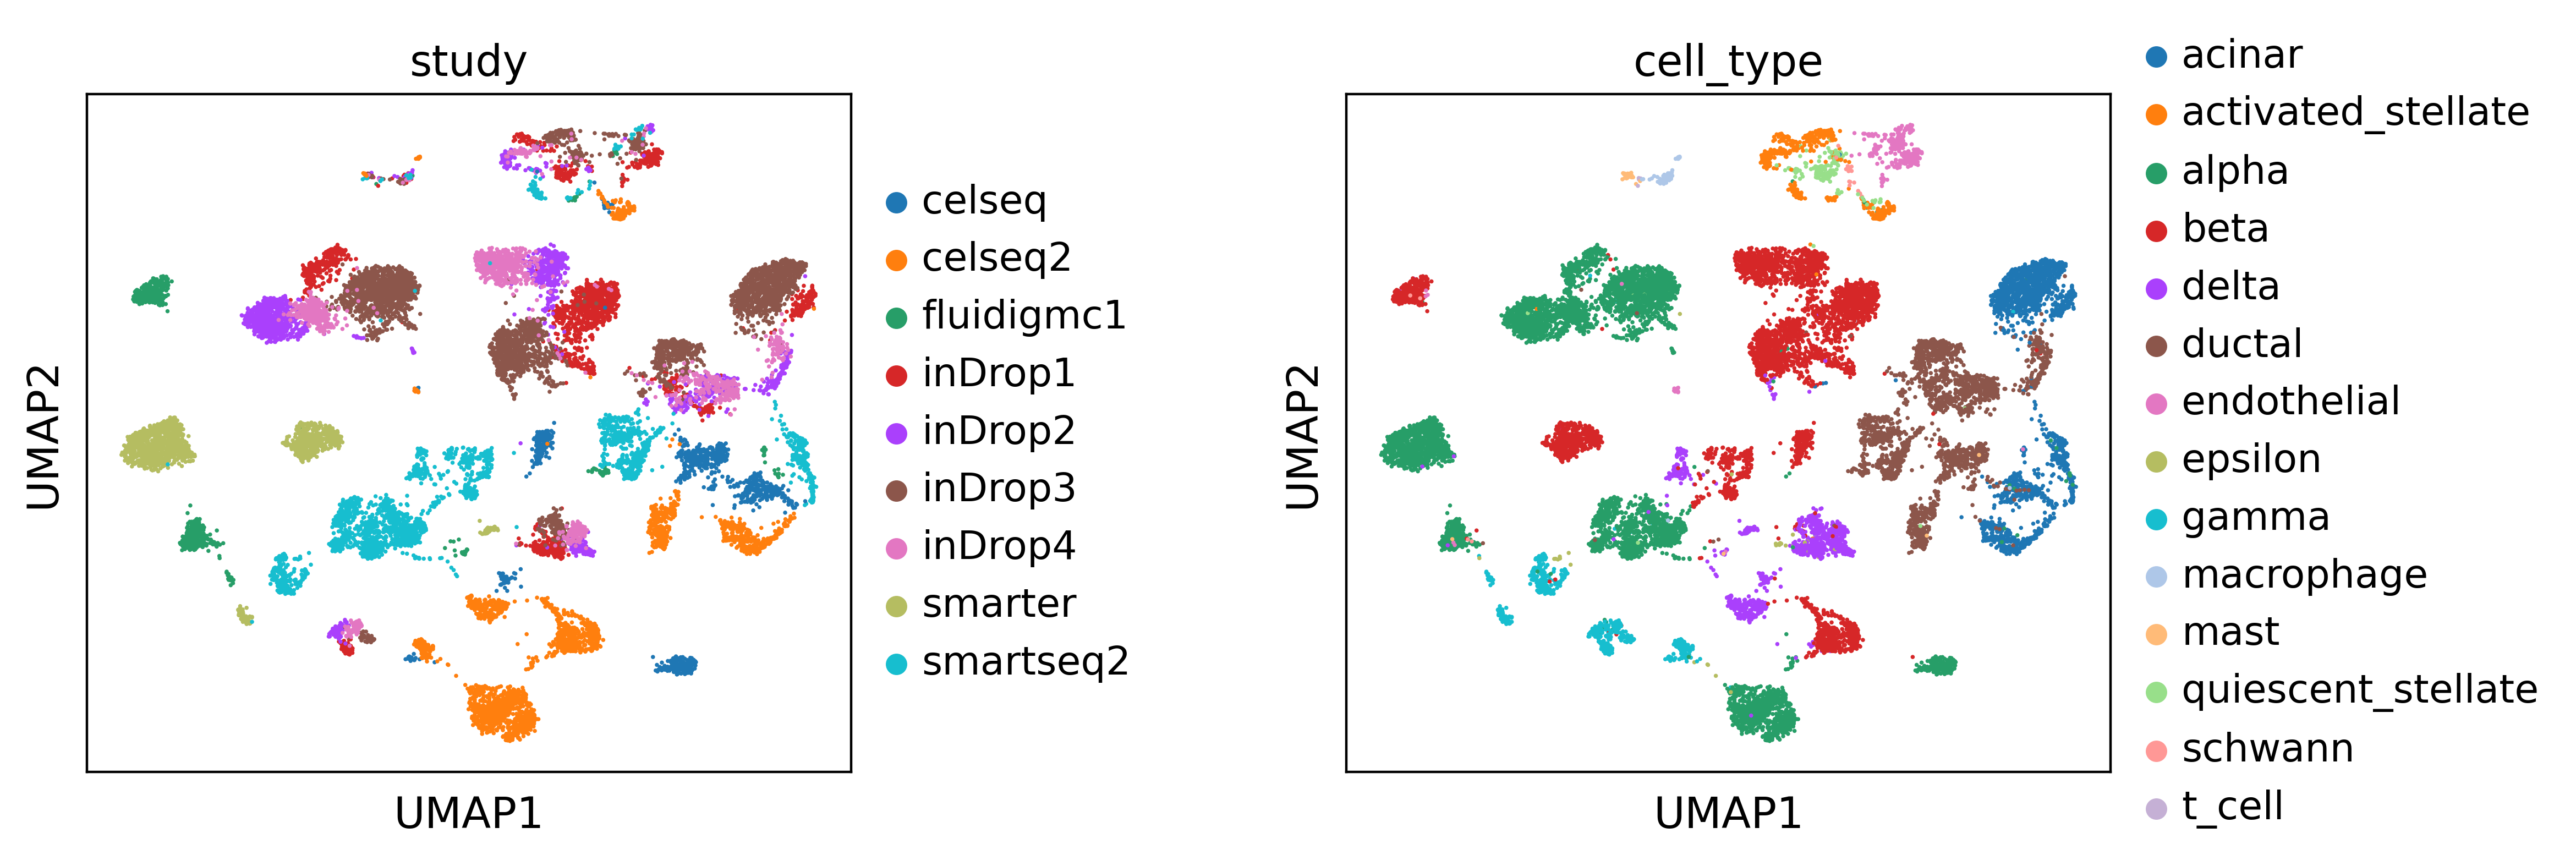

In [4]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.5)

In [10]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'study'
cell_type_key = ['cell_type']
reference = [
    'inDrop1', 
    'inDrop2', 
    'inDrop3', 
    'inDrop4', 
    'fluidigmc1', 
    'smartseq2', 
    'smarter'
]
query = ['celseq', 'celseq2']

# Reference - query split
We split our data in a group of reference datasets to be used for reference building, and a group of query datasets that we will map.

In order to simulate an unknown cell type scenario, we manually remove beta cells from the reference.

In [11]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
source_adata = source_adata[~source_adata.obs.cell_type.str.contains('alpha')].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [12]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 8634 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3289 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities')

# Train reference scPoli model on fully labeled reference data

In [13]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dim=3,
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 3
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 3
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 3
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 



In [14]:
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

 |████████████████████| 100.0%  - val_loss: 1073.8617292132 - val_trvae_loss: 1066.8211321150 - val_prototype_loss: 7.0406092235 - val_labeled_loss: 1.4081218413
Saving best state of network...
Best State was in Epoch 49


# Reference mapping of unlabeled query datasets

In [15]:
scpoli_query = scPoli.load_query_data(
    adata=target_adata,
    reference_model=scpoli_model,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 3
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 3
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 3
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 



In [16]:
scpoli_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    eta=5
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████████████----| 80.0%  - val_loss: 1856.6254069010 - val_trvae_loss: 1856.6254069010
Initializing unlabeled prototypes with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 16 clusters.
 |████████████████████| 100.0%  - val_loss: 1838.3502604167 - val_trvae_loss: 1838.3502604167 - val_prototype_loss: 0.0000000000 - val_unlabeled_loss: 0.0000000000
Saving best state of network...
Best State was in Epoch 49


# Label transfer from reference to query

In [17]:
results_dict = scpoli_query.classify(
    target_adata.X, 
    target_adata.obs[condition_key], 
)

Let's check the label transfer performance we achieved.

In [18]:
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]["preds"]
    results_dict[cell_type_key[i]]["uncert"]
    classification_df = pd.DataFrame(
        classification_report(
            y_true=target_adata.obs[cell_type_key[i]],
            y_pred=preds,
            output_dict=True,
        )
    ).transpose()
print(classification_df)

                    precision    recall  f1-score      support
acinar               0.963783  0.954183  0.958959   502.000000
activated_stellate   0.893443  1.000000  0.943723   109.000000
alpha                0.000000  0.000000  0.000000  1034.000000
beta                 0.948963  0.981848  0.965126   606.000000
delta                0.691460  0.992095  0.814935   253.000000
ductal               0.951424  0.970940  0.961083   585.000000
endothelial          1.000000  1.000000  1.000000    26.000000
epsilon              0.007987  1.000000  0.015848     5.000000
gamma                0.320802  1.000000  0.485769   128.000000
macrophage           1.000000  0.937500  0.967742    16.000000
mast                 1.000000  0.714286  0.833333     7.000000
quiescent_stellate   1.000000  0.538462  0.700000    13.000000
schwann              1.000000  1.000000  1.000000     5.000000
accuracy             0.666768  0.666768  0.666768     0.666768
macro avg            0.752143  0.853024  0.742040  3289

In [37]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata.X, 
    source_adata.obs[condition_key].values,
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata.X, 
    target_adata.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)

#get prototypes
labeled_prototypes = scpoli_query.get_prototypes_info()
labeled_prototypes.obs['study'] = 'labeled prototype'
unlabeled_prototypes = scpoli_query.get_prototypes_info(prototype_set='unlabeled')
unlabeled_prototypes.obs['study'] = 'unlabeled prototype'

#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent, labeled_prototypes, unlabeled_prototypes], 
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

In [38]:
#get adata without prototypes
adata_no_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['0', '1'])]

<AxesSubplot: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

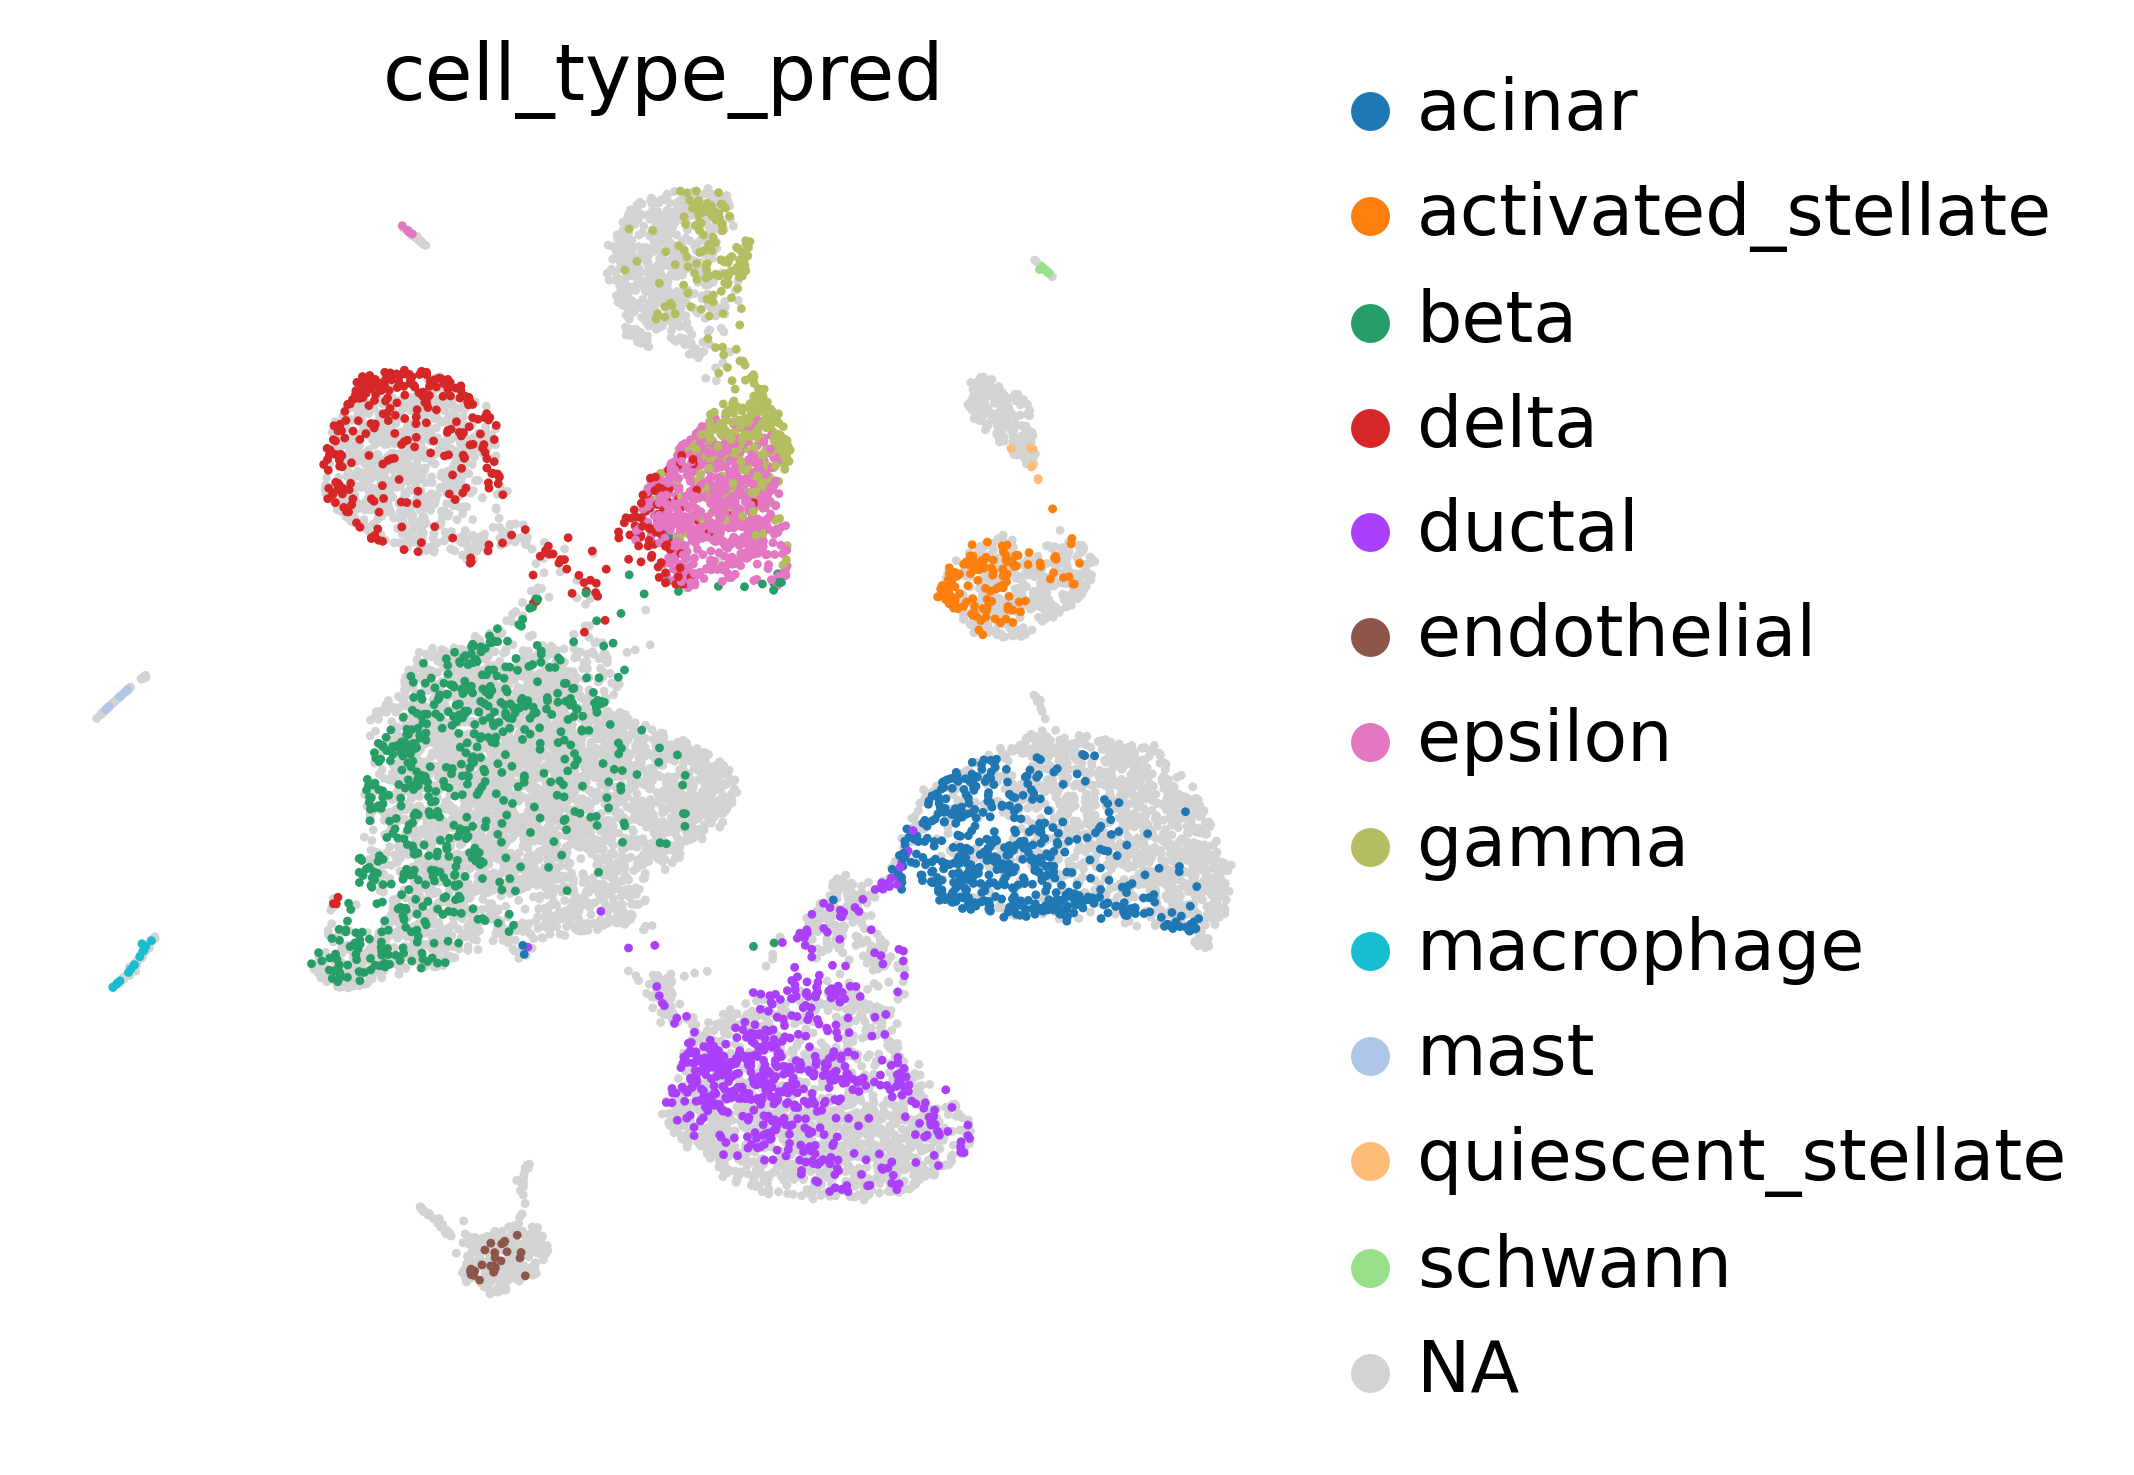

In [39]:
sc.pl.umap(
    adata_no_prototypes, 
    color='cell_type_pred',
    show=False, 
    frameon=False,
)

<AxesSubplot: title={'center': 'study'}, xlabel='UMAP1', ylabel='UMAP2'>

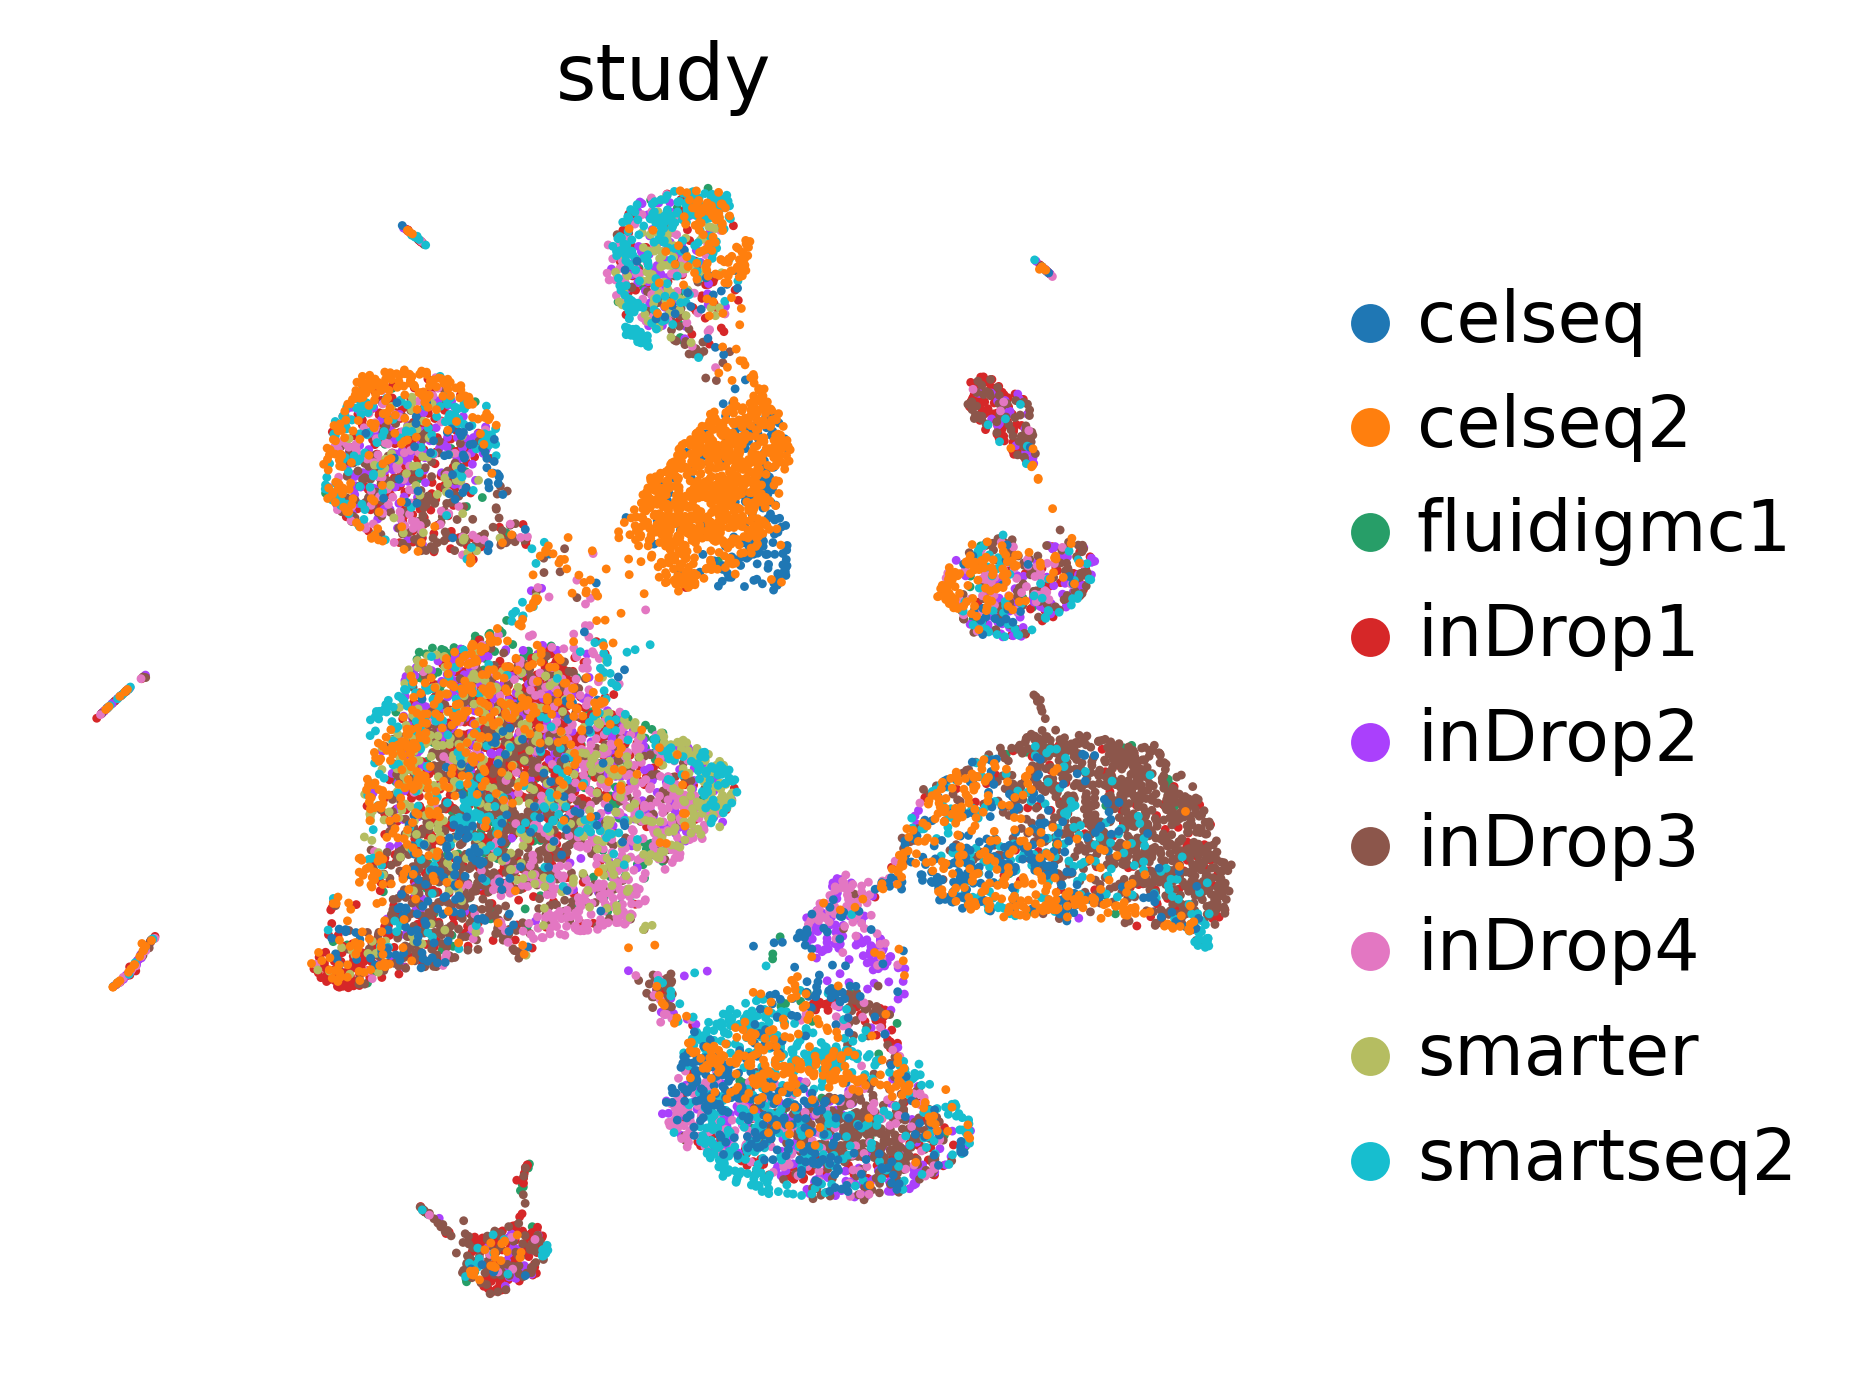

In [40]:
sc.pl.umap(
    adata_no_prototypes, 
    color='study',
    show=False, 
    frameon=False,
)

# Inspect uncertainty
We can look at the uncertainty of each prediction and either select a threshold after visual inspection or by looking at the percentiles of the uncertainties distribution.

<AxesSubplot: title={'center': 'cell_type_uncert'}, xlabel='UMAP1', ylabel='UMAP2'>

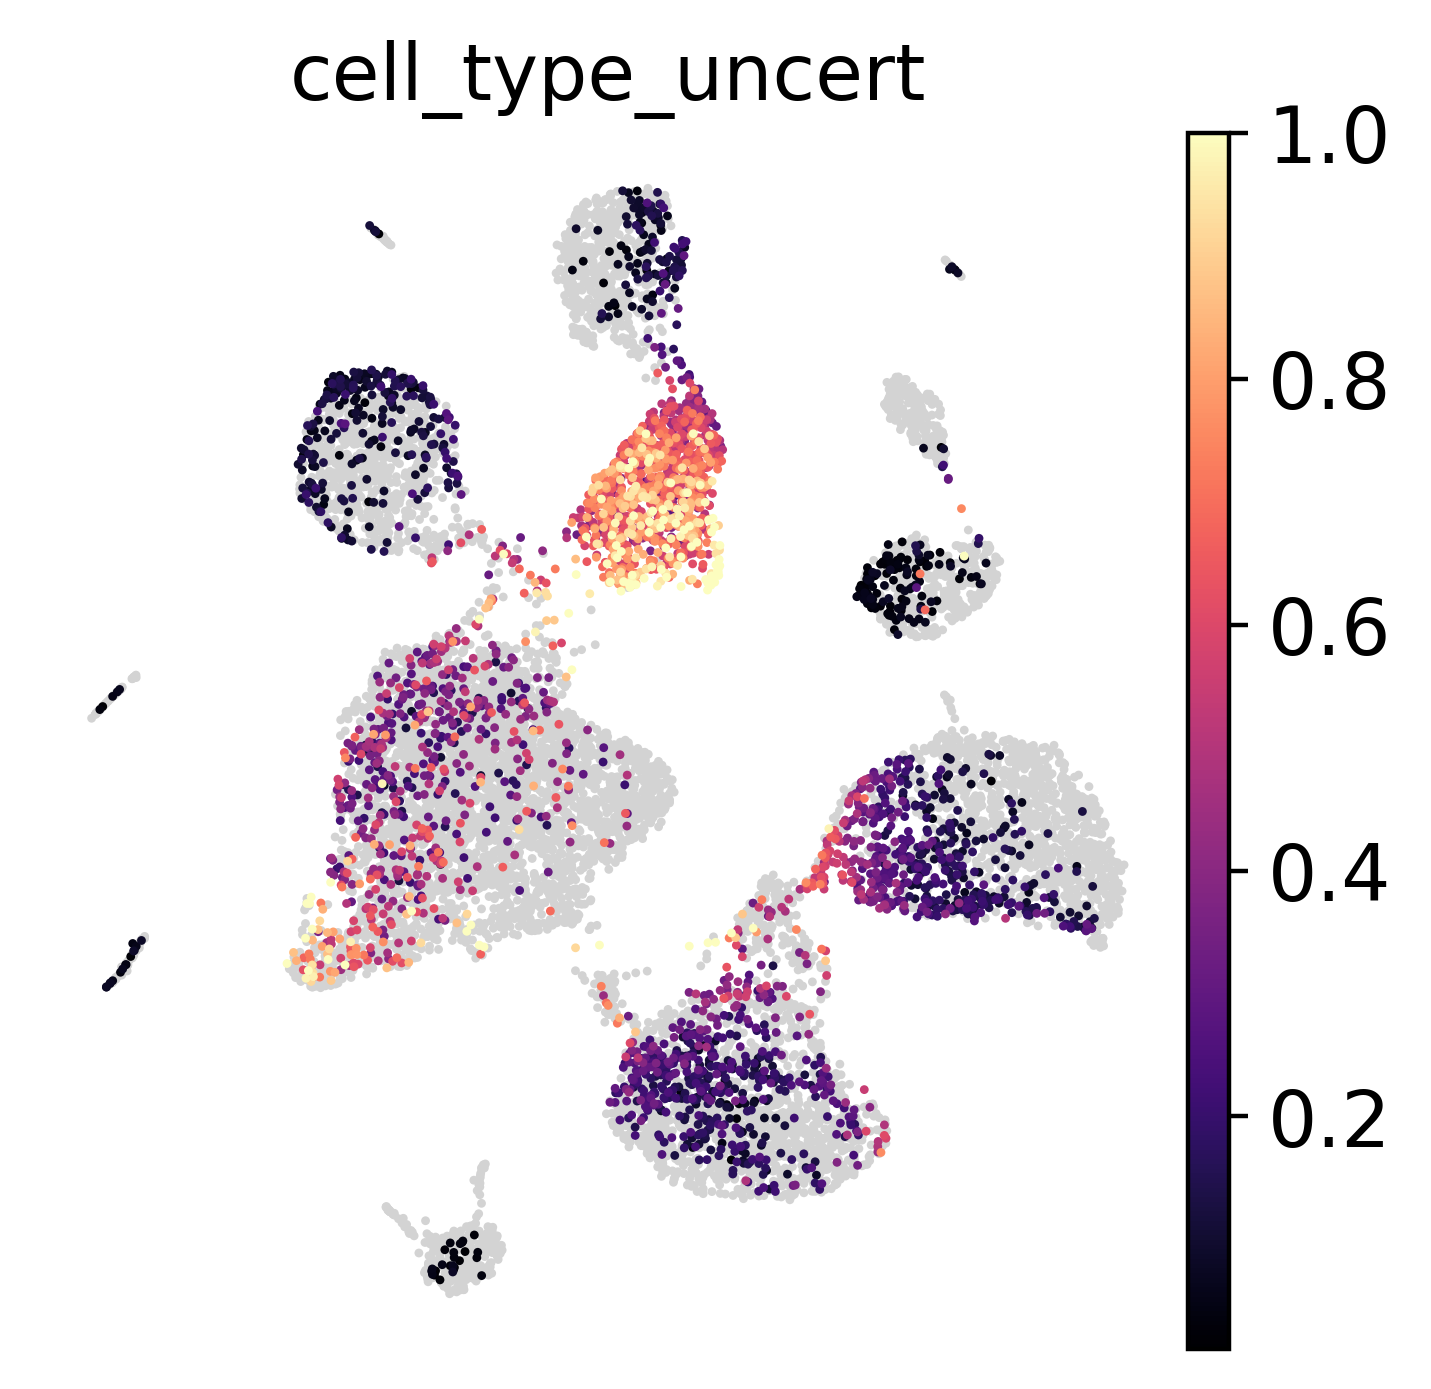

In [41]:
sc.pl.umap(
    adata_no_prototypes, 
    color='cell_type_uncert',
    show=False, 
    frameon=False,
    cmap='magma',
    vmax=1
)

# Inspect prototypes

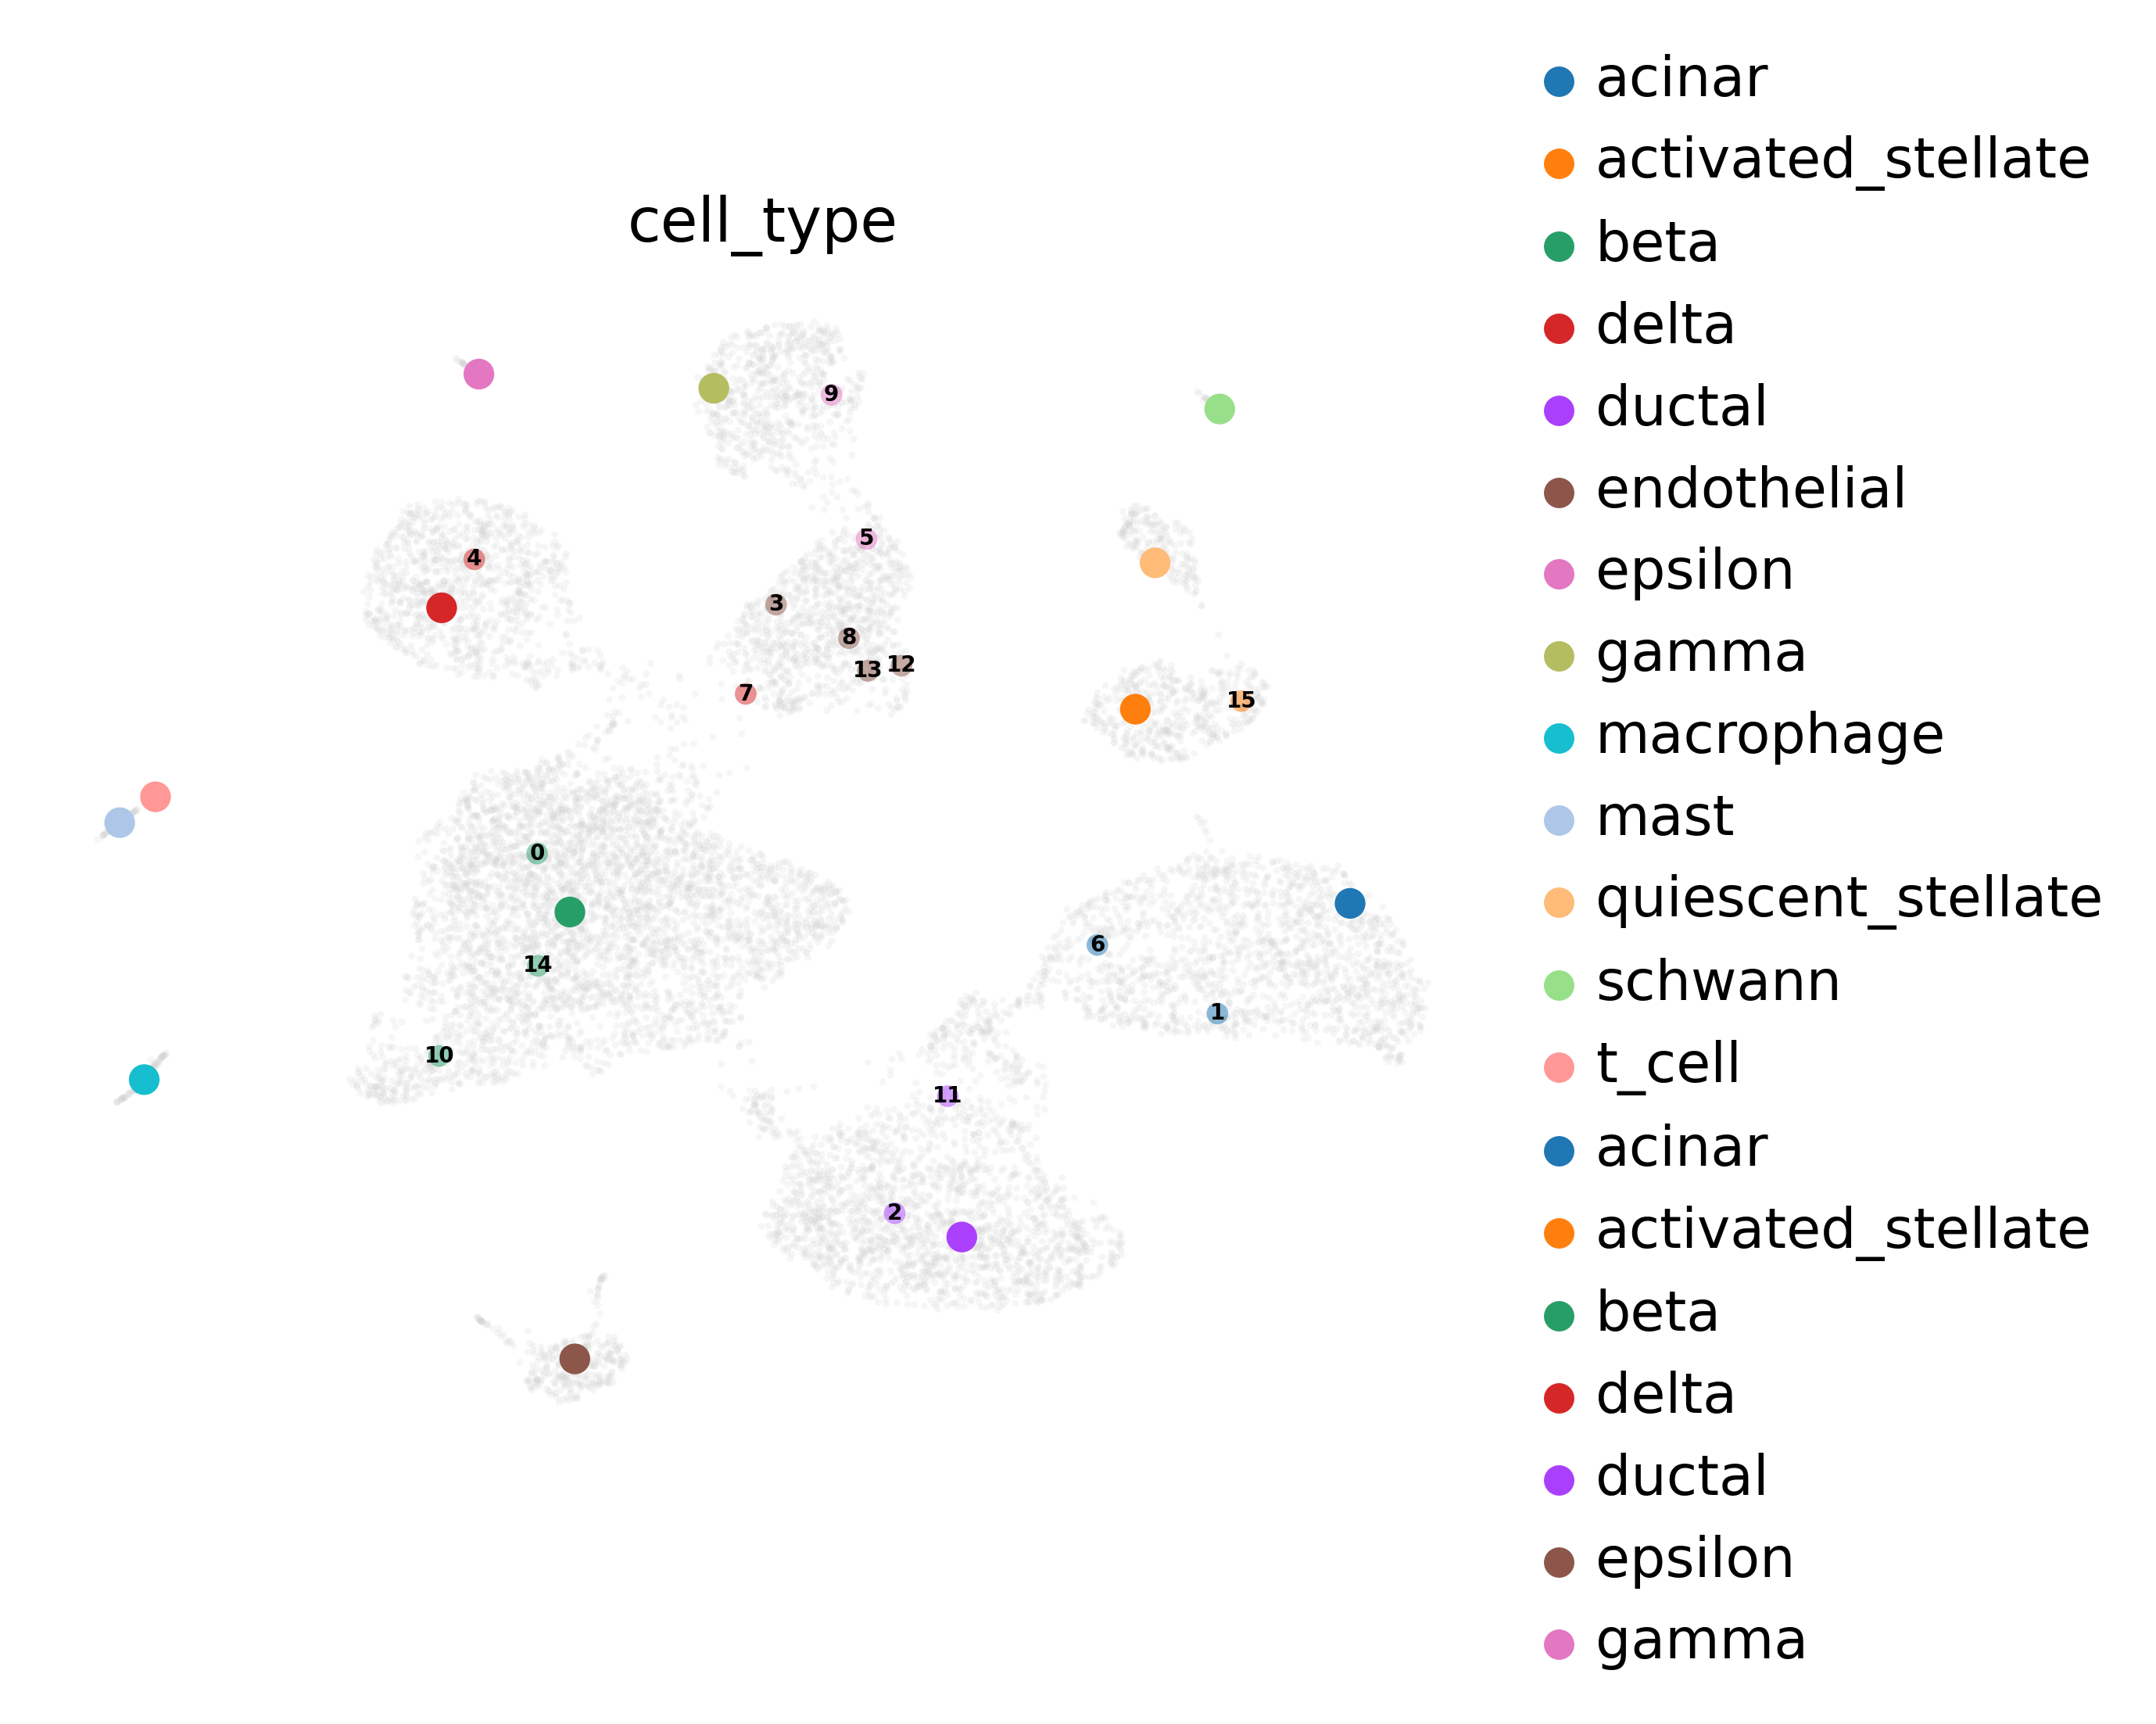

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
adata_labeled_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['2'])]
adata_unlabeled_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['3'])]
adata_labeled_prototypes.obs['cell_type_pred'] = adata_labeled_prototypes.obs['cell_type_pred'].astype('category')
adata_unlabeled_prototypes.obs['cell_type_pred'] = adata_unlabeled_prototypes.obs['cell_type_pred'].astype('category')
adata_unlabeled_prototypes.obs['cell_type'] = adata_unlabeled_prototypes.obs['cell_type'].astype('category')

sc.pl.umap(
    adata_no_prototypes, 
    alpha=0.2, 
    show=False, 
    ax=ax
)
ax.legend([])
# plot labeled prototypes
sc.pl.umap(
    adata_labeled_prototypes,
    size=200,
    color=f'{cell_type_key[0]}_pred',
    ax=ax,
    show=False,
    frameon=False,
)
# plot labeled prototypes
sc.pl.umap(
    adata_unlabeled_prototypes,
    size=100,
    color=[cell_type_key[0] + '_pred'],
    palette=adata_labeled_prototypes.uns['cell_type_pred_colors'],
    ax=ax,
    show=False,
    frameon=False,
    alpha=0.5,
)
sc.pl.umap(
    adata_unlabeled_prototypes,
    size=0,
    color=cell_type_key[0],
    frameon=False,
    ax=ax,
    legend_loc='on data',
    legend_fontsize=5,
)
ax.set_title('Landmarks')
fig.tight_layout()

After inspecting the prototypes we can observe that unlabeled prototype 3, 5, 7, 8, 12 and 13 fall into the region of high uncertainty. With this knowledge, we can add a new labeled prototype.

In [62]:
scpoli_query.add_new_cell_type(
    "alpha", 
    cell_type_key[0], 
    [3, 5, 7, 8, 12, 13]
)

In [63]:
results_dict = scpoli_query.classify(
    target_adata.X, 
    target_adata.obs[condition_key], 
)

In [64]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata.X, 
    source_adata.obs[condition_key].values,
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata.X, 
    target_adata.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)

#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent, labeled_prototypes, unlabeled_prototypes], 
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

<AxesSubplot: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

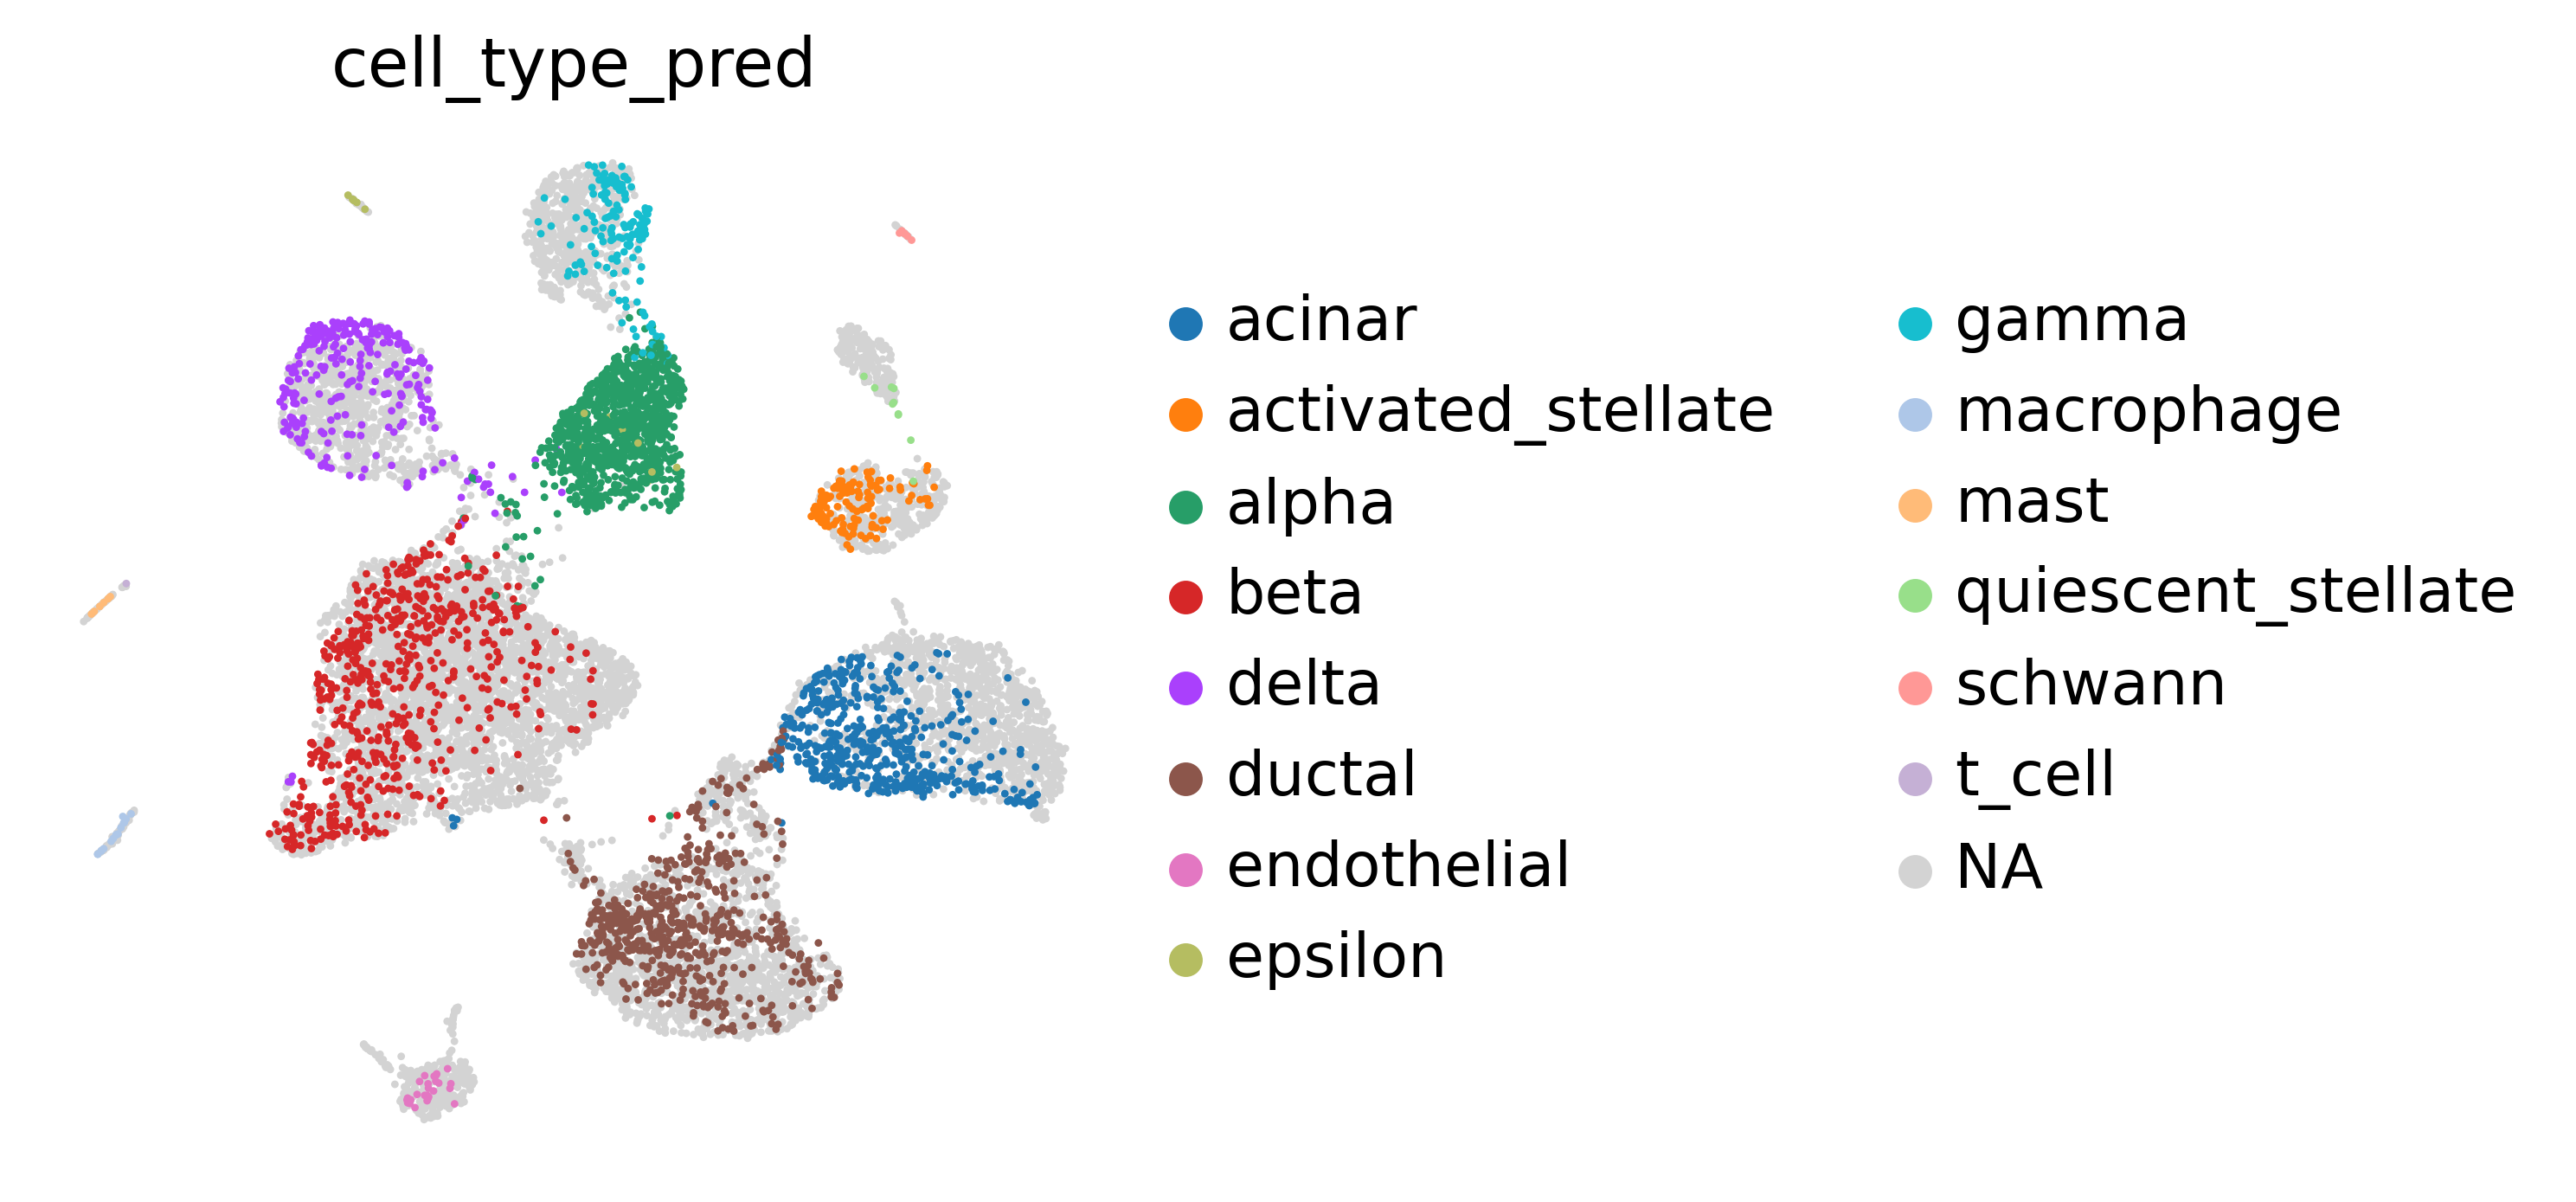

In [69]:
sc.pl.umap(
    adata_latent_full, 
    color='cell_type_pred',
    show=False, 
    frameon=False,
)

We can now see that the alpha cell cluster is correctly classified.

# Sample embeddings

We can extract the conditional embeddings learnt by scPoli and analyse them.

In [70]:
adata_emb = scpoli_query.get_conditional_embeddings()

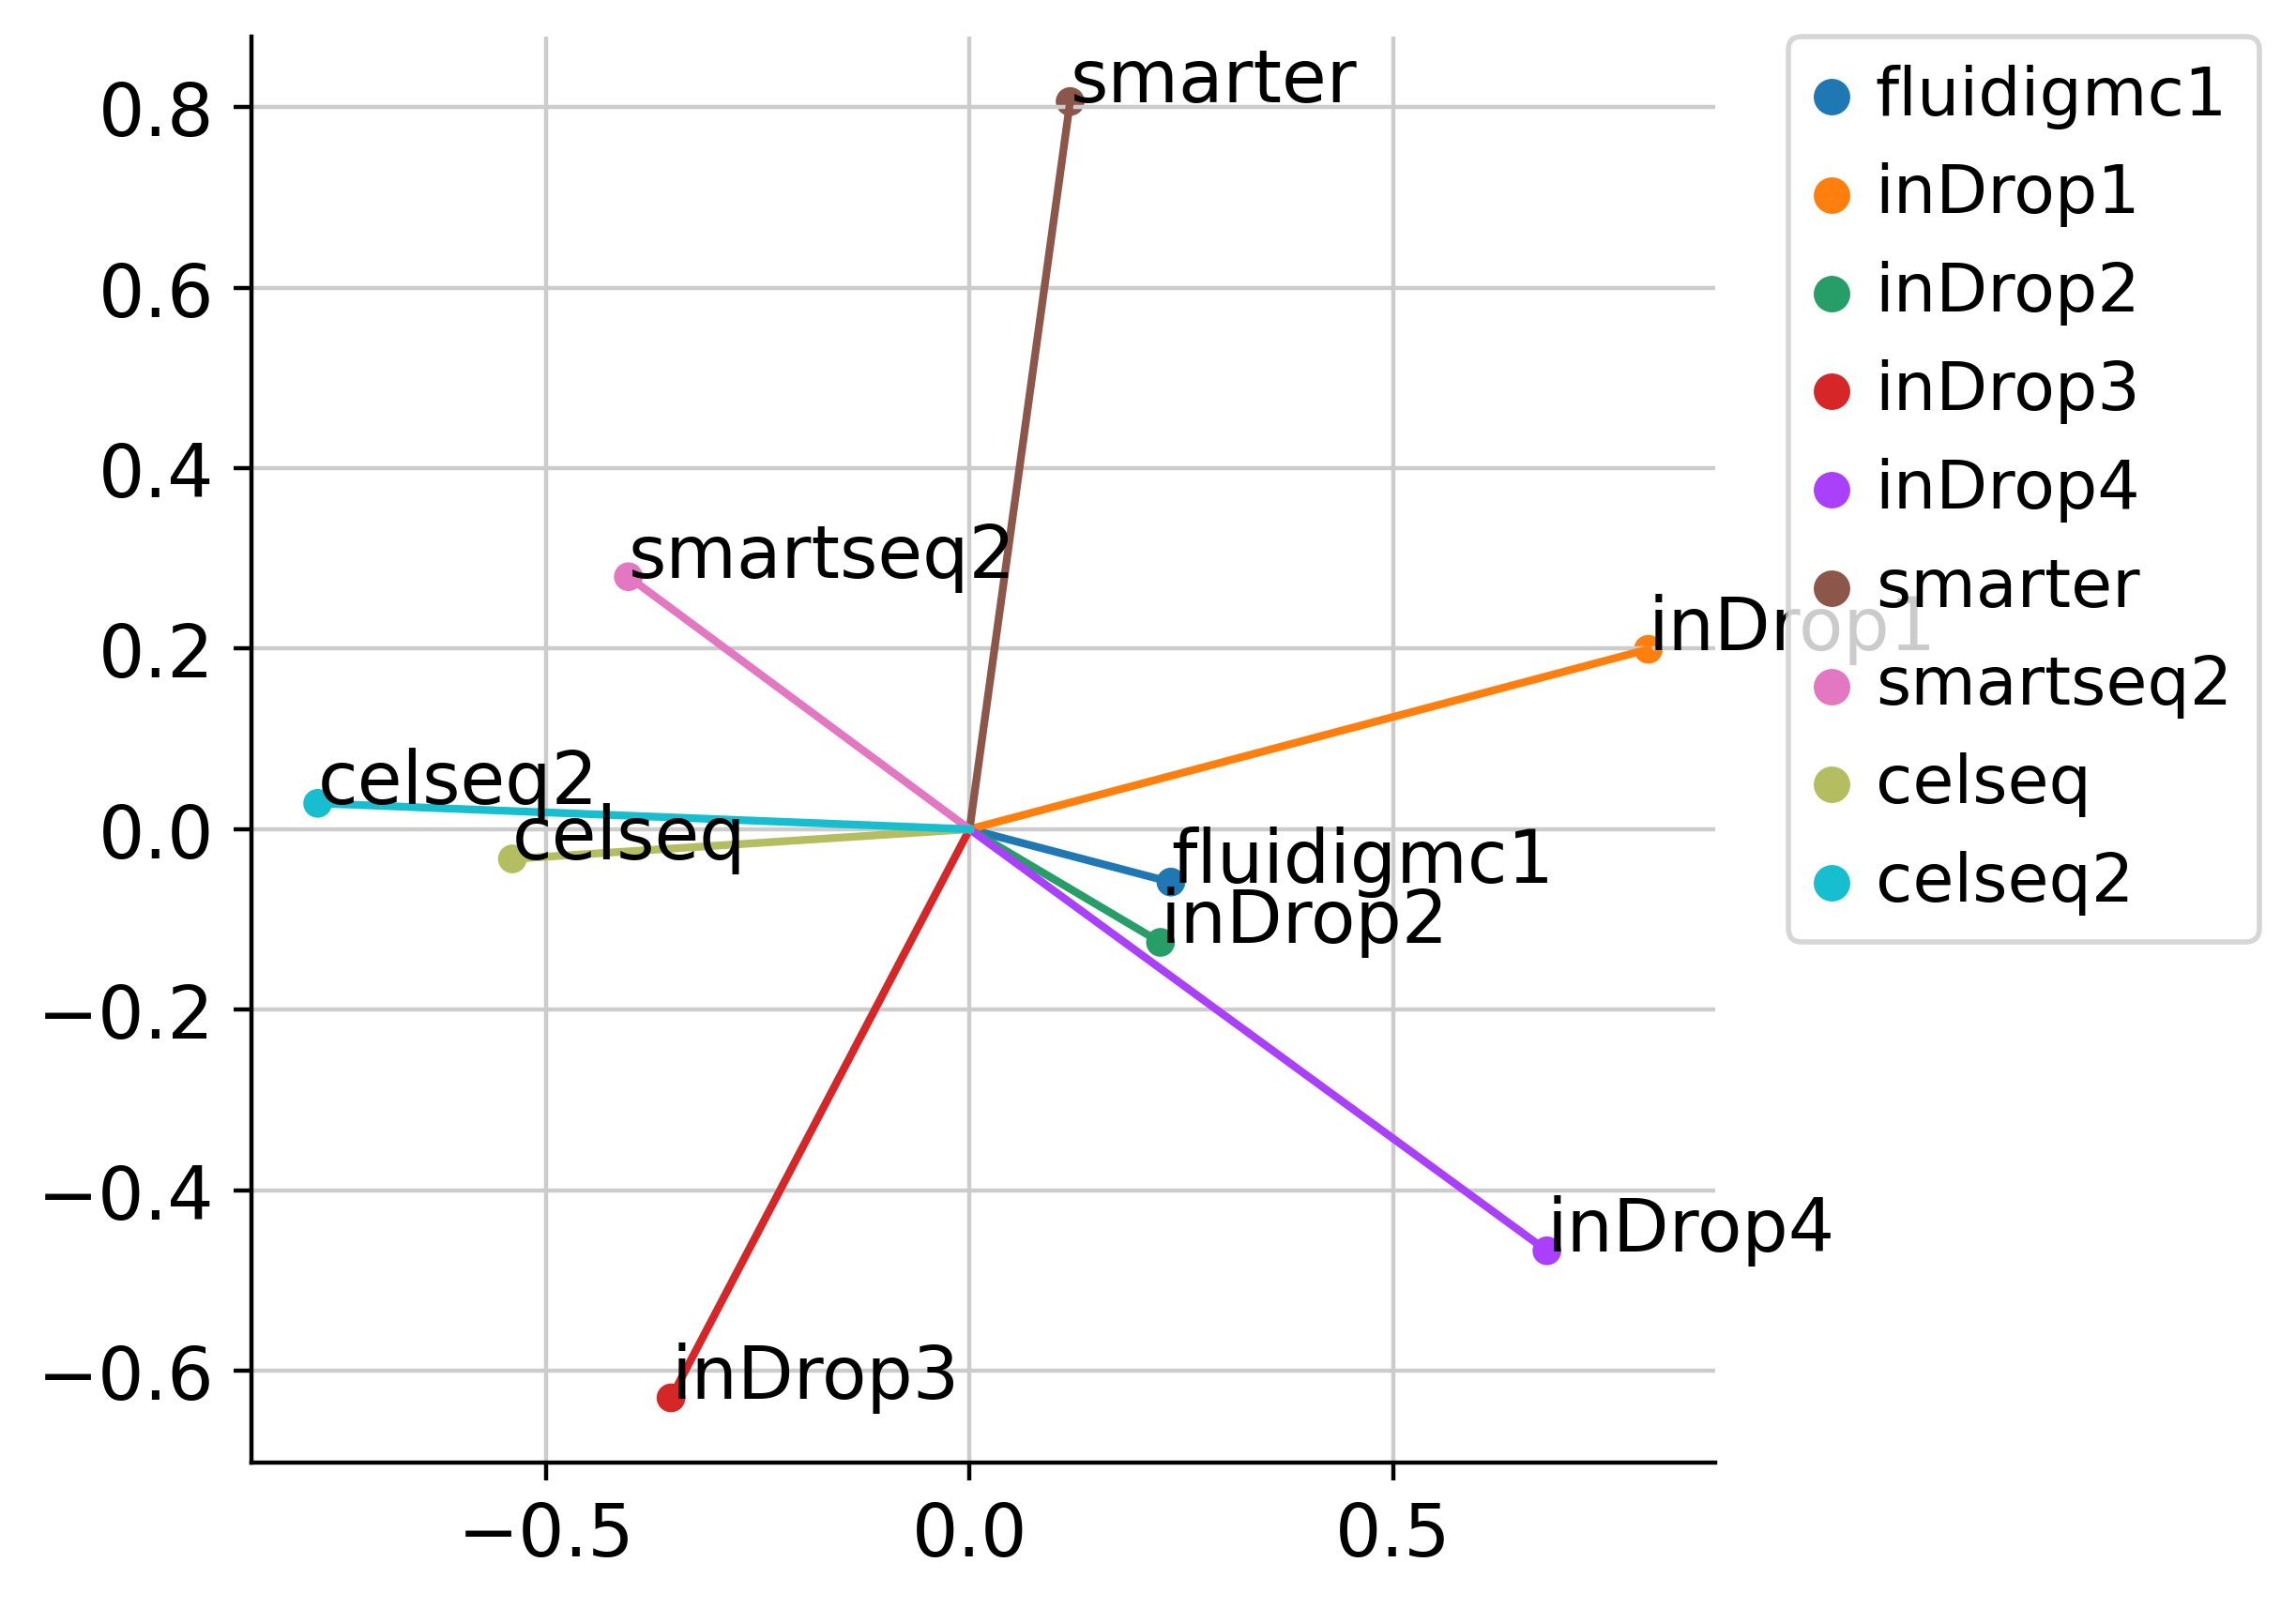

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(adata_emb.X)
conditions = scpoli_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=emb_pca[:, 0], y=emb_pca[:, 1], hue=conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()